In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import RFECV
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Coletando e tratando os dados das ações VALE3:
vale = yf.download('VALE3.SA', start='2022-01-03', end='2025-07-23', multi_level_index=False)
vale = vale[['Close', 'Open', 'Volume']]
vale.reset_index(inplace=True)
vale['Date'] = pd.to_datetime(vale['Date'])
vale.set_index('Date', inplace=True)
vale.rename(columns={
    'Close': 'Close_Preco_VALE3',
    'Open': 'Open_Preco_VALE3',
    'Volume': 'Variacao_Preco_VALE3'
}, inplace=True)

# Vamos pegar os dados do preço do minério de ferro:
minerio_ferro = pd.read_csv('Dados Históricos - Minério de ferro refinado 62% Fe CFR Futuros.csv')
minerio_ferro.reset_index(inplace=True)
minerio_ferro['Data'] = pd.to_datetime(minerio_ferro['Data'], dayfirst=True)
minerio_ferro.set_index('Data', inplace=True)
minerio_ferro = minerio_ferro[['Último','Abertura', 'Var%']]
# Invertendo a ordem das datas:
minerio_ferro = minerio_ferro.iloc[::1]
minerio_ferro.rename(columns={
    'Último': 'Close_Preco_Ferro',
    'Abertura': 'Open_Preco_Ferro',
    'Var%': 'Variacao_ferro'
}, inplace=True)

# Unindo o dataframe da VALE3 com o dataset de Minerrio de Ferro:
df = pd.merge(vale, minerio_ferro, left_index=True, right_index=True, suffixes=('_VALE3', '_Minerio'))

# Variação percentual do preço de fechamento da VALE3:
df['Variação_VALE3'] = df['Close_Preco_VALE3'].pct_change() * 100
# Trocando nan por 0%:
df['Variação_VALE3'].fillna(0, inplace=True)

# Vamos transformar as colunas Close_Minerio, Open_Minerio e Variação_Minerio em float:
df['Close_Preco_Ferro'] = df['Close_Preco_Ferro'].str.replace(',', '.', regex=False).astype(float)
df['Open_Preco_Ferro'] = df['Open_Preco_Ferro'].str.replace(',', '.', regex=False).astype(float)
df['Variacao_ferro'] = df['Variacao_ferro'].str.replace('%', '', regex=False).str.replace(',', '.', regex=False).astype(float)

# Variação percentual do preço de fechamento do minério de ferro:
df['Variação_Preco_Fechamento_Ferro'] = df['Close_Preco_Ferro'].pct_change() * 100 
# Trocando nan por 7,02%:
df['Variação_Preco_Fechamento_Ferro'].fillna(7.02, inplace=True)

df.reset_index(inplace=True)
df['index'] = pd.to_datetime(df['index'], dayfirst=True)
df.rename(columns={'index': 'Data'}, inplace=True)
df.set_index('Data', inplace=True)

# Médias móveis para os preços da VALE3:
df['MM_7D_VALE3'] = df['Close_Preco_VALE3'].rolling(window=7, min_periods=1).mean()
df['MM_20D_VALE3'] = df['Close_Preco_VALE3'].rolling(window=20, min_periods=1).mean()
df['MM_200D_VALE3'] = df['Close_Preco_VALE3'].rolling(window=200, min_periods=1).mean()

# Médias móveis para os preços da commodite do minério de ferro:
df['MM_7D_Ferro'] = df['Close_Preco_Ferro'].rolling(window=7, min_periods=1).mean()
df['MM_20D_Ferro'] = df['Close_Preco_Ferro'].rolling(window=20, min_periods=1).mean()
df['MM_200D_Ferro'] = df['Close_Preco_Ferro'].rolling(window=200, min_periods=1).mean()

df[['MM_7D_VALE3','MM_20D_VALE3','MM_200D_VALE3','MM_7D_Ferro','MM_20D_Ferro','MM_200D_Ferro']]

df['Retorno_1D'] = df['Close_Preco_VALE3'].pct_change() * 100
df['Retorno_1D'].fillna(0, inplace=True)
df['Retorno_7D'] = df['Close_Preco_VALE3'].pct_change(7) * 100 
df['Retorno_7D'].fillna(0, inplace=True)
df['Retorno_21D'] = df['Close_Preco_Ferro'].pct_change(21) * 100
df['Retorno_21D'].fillna(0, inplace=True)

df['Volatilidade_7D_VALE3'] = np.std(df['Retorno_7D'])
df['Volatilidadde_21D_VALE3'] = np.std(df['Retorno_21D'])
df['Volatilidade_7D_VALE3'].fillna(0, inplace=True)
df['Volatilidadde_21D_VALE3'].fillna(0, inplace=True)

def calcular_rsi(series, window=14):
    delta = series.diff()

    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_again = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_again / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

df['RSI_14'] = calcular_rsi(df['Close_Preco_VALE3'], window=14)
df['RSI_14'].fillna(df['RSI_14'].mean(), inplace=True)

MME_12 = df['Close_Preco_VALE3'].ewm(span=12, adjust=False).mean()
MME_26 = df['Close_Preco_VALE3'].ewm(span=26, adjust=False).mean()

df['MACD'] = MME_12 - MME_26

df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# primeiro pegamos as medias móveis de 20 dias:
medias_20D = df['MM_20D_VALE3']
# E o desvio padrão de 20 dias também:
desvio_20D = df['Close_Preco_VALE3'].rolling(window=20, min_periods=1).std()

# Assim podemos calcular as bandas:
df['banda_media'] = medias_20D
df['banda_superior'] = medias_20D + (2 * desvio_20D)
df['banda_inferior'] = medias_20D - (2 * desvio_20D)

# Vamos completar os valores NaN com a média dos dados para cada coluna:
df['banda_inferior'].fillna(df['banda_inferior'].mean(), inplace=True)
df['banda_superior'].fillna(df['banda_superior'].mean(), inplace=True)
df[['banda_media', 'banda_superior', 'banda_inferior']]

def Rolling_Sharpe_Ratio(returns, window=21, risk_free_rate=0.0, trading_days=252):
    # Converter taxa livre de risco para diária:
    rf_daily = (1 + risk_free_rate)**(1/trading_days) - 1

    # Calcular retornos excedentes:
    excess_return = returns - rf_daily

    # Média móvel dos retornos excedentes:
    mean_returns = excess_return.rolling(window).mean()

    # Desvio padrão móvel dos retornos excedentes:
    std_returns = excess_return.rolling(window).std()

    # Sharpe Ratio anualizado:
    sharpe_ratio = mean_returns / std_returns * np.sqrt(trading_days)

    return sharpe_ratio

# Calculando o sharpe ratio de 21 dias( 21 dias = 1 mês de trading):
df['Sharpe_21D'] = Rolling_Sharpe_Ratio(
    returns=df['Retorno_1D'],
    window=21,
    risk_free_rate= 0.15, # 15% ao ano (SELIC atual)
    trading_days=252
)

[*********************100%***********************]  1 of 1 completed


In [13]:
df['Sharpe_21D'].fillna(df['Sharpe_21D'].mean(), inplace=True)
df['Sharpe_21D'].isnull().sum()

0

* Pré-Processamento:

In [14]:
from sklearn.preprocessing import RobustScaler

# Remoção de features altamente correlacionadas (reduz overfitting):
corr_matrix = df.corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]
df.drop(to_drop, axis=1, inplace=True)

# Normalização robusta (preserva outliers financeiros)
scaler = RobustScaler()
feature_cols = [col for col in df.columns if col != 'Close_Preco_VALE3']
df[feature_cols] = scaler.fit_transform(df[feature_cols])

df

,Close_Preco_VALE3,Variacao_Preco_VALE3,Close_Preco_Ferro,Variacao_ferro,Variação_VALE3,MM_200D_VALE3,MM_200D_Ferro,Retorno_7D,Retorno_21D,Volatilidade_7D_VALE3,Volatilidadde_21D_VALE3,RSI_14,MACD,Sharpe_21D
Data,,,,,,,,,,,,,,
2022-01-03,57.766415,-0.399270,0.464194,9.716263,0.019498,-0.764981,0.255739,0.000000,0.059674,0.0,0.0,-0.003165,0.066633,0.000000
2022-01-04,57.085068,-0.427240,0.485934,0.581315,-0.538818,-0.835431,0.276156,0.000000,0.059674,0.0,0.0,-0.003165,0.031836,0.000000
2022-01-05,57.625702,-0.141975,0.623615,3.695502,0.467797,-0.821647,0.369168,0.000000,0.059674,0.0,0.0,-0.003165,0.032581,0.000000
2022-01-06,58.788433,-0.141598,0.700341,2.006920,0.974600,-0.754643,0.451704,0.000000,0.059674,0.0,0.0,-0.003165,0.092934,0.000000
2022-01-07,62.209988,0.831553,0.711850,0.290657,2.774477,-0.572929,0.505549,0.000000,0.059674,0.0,0.0,-0.003165,0.314660,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-16,54.400002,0.179855,-0.530691,0.802768,0.449742,-1.409769,-1.287423,0.003166,0.217732,0.0,0.0,0.716397,0.414498,0.405263
2025-07-17,54.299999,-0.273970,-0.525575,0.166090,-0.067518,-1.411325,-1.285325,-0.088326,0.243423,0.0,0.0,0.484496,0.389679,0.131098
2025-07-18,54.560001,-0.018197,-0.523870,0.055363,0.246152,-1.412335,-1.283227,0.165672,0.282925,0.0,0.0,0.382105,0.379830,0.663096


* divisão de dados:

In [17]:
# Divisão temporal
train_size = int(0.8 * len(df))
train = df.iloc[:train_size]
test = df.iloc[train_size:]

# Criação de versões diferenciadas para prever retornos:
df['Target_Retorno_1D'] = df['Close_Preco_VALE3'].pct_change().shift(-1)

# Separar features e target:
X_train = train.drop(columns=['Close_Preco_VALE3', 'Target_Retorno_1D'])
y_train = train['Target_Retorno_1D']
X_test = test.drop(columns=['Close_Preco_VALE3', 'Target_Retorno_1D'])
y_test = test['Target_Retorno_1D']

# Validação Cruzada Temporal:
tscv = TimeSeriesSplit(n_splits=5)

for train_index, val_index in tscv.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]



* Implementação do modelo XGBoost:

In [33]:
# 1. Configuração do modelo
modelo = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.7,
    gamma=0.1,
    reg_alpha=0.5,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

# 2. Treino com early stopping manual
best_rounds = None
best_score = float('inf')

for train_idx, val_idx in TimeSeriesSplit(n_splits=5).split(X_train):
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    modelo.fit(X_fold_train, y_fold_train)
    
    # Avaliação
    preds_val = modelo.predict(X_fold_val)
    current_score = mean_absolute_error(y_fold_val, preds_val)
    
    if current_score < best_score:
        best_score = current_score
        best_rounds = modelo.best_iteration if hasattr(modelo, 'best_iteration') else len(modelo.get_booster().get_dump())

# 3. Treino final com o melhor número de rounds
modelo = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=best_rounds,  # Usa o melhor número de iterações
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.7,
    gamma=0.1,
    reg_alpha=0.5,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

modelo.fit(X_train, y_train)

y_test = y_test.dropna()

# 4. Avaliação final
preds = modelo.predict(X_test)

In [ ]:
if len(y_test) != len(preds):
    # Ajustar para o menor tamanho
    min_length = min(len(y_test), len(preds))
    y_test_aligned = y_test[:min_length]
    preds_aligned = preds[:min_length]
    
    # Verificar novamente
    print("\nApós alinhamento:")
    print(f"Shape do y_test: {y_test_aligned.shape}")
    print(f"Shape das predições: {preds_aligned.shape}")
else:
    y_test_aligned = y_test
    preds_aligned = preds

# 3. Cálculo seguro do MAPE
try:
    mape = mean_absolute_percentage_error(y_test_aligned, preds_aligned) 
    print(f"\nMAPE calculado com sucesso: {mape:.2f}%")
except Exception as e:
    print(f"\nErro no cálculo do MAPE: {str(e)}")


Após alinhamento:
Shape do y_test: (171,)
Shape das predições: (171,)

MAPE calculado com sucesso: 1.02%


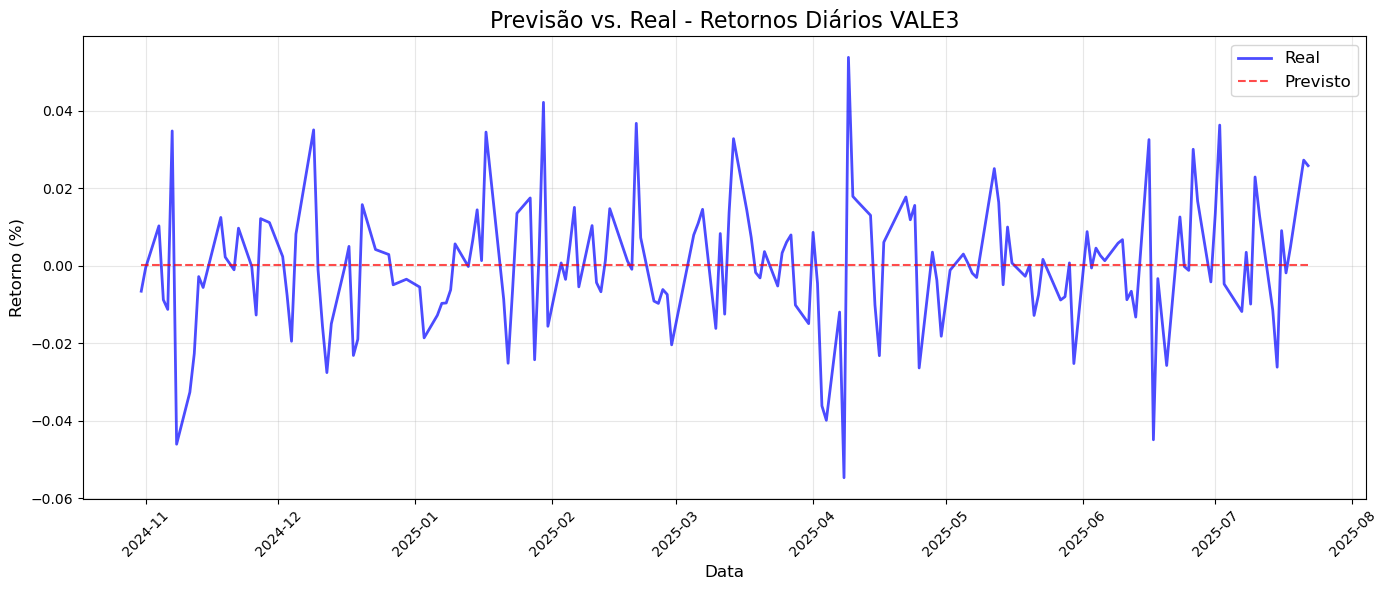

In [37]:
# Garantir alinhamento dos dados
y_test_aligned = y_test_aligned.values if hasattr(y_test_aligned, 'values') else y_test_aligned
preds_aligned = preds_aligned.flatten() if hasattr(preds_aligned, 'flatten') else preds_aligned

# Criar DataFrame para facilitar a plotagem
results = pd.DataFrame({
    'Real': y_test_aligned,
    'Previsto': preds_aligned
}, index=test.index[-len(y_test_aligned):])  # Ajuste o índice conforme necessário

# Plotar
plt.figure(figsize=(14, 6))
plt.plot(results.index, results['Real'], label='Real', color='blue', alpha=0.7, linewidth=2)
plt.plot(results.index, results['Previsto'], label='Previsto', color='red', linestyle='--', alpha=0.7)

# Configurações do gráfico
plt.title('Previsão vs. Real - Retornos Diários VALE3', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Retorno (%)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Rotacionar datas para melhor visualização
plt.xticks(rotation=45)

plt.tight_layout()  # Evitar cortes nos rótulos
plt.show()